### Install Procsim

In [1]:
#!pip install procsimulator==0.1.0

### Import Modules

In [2]:
import procsimulator
import os
import pandas as pd
import matplotlib.pyplot as plt
import ortools

In [3]:
from procsimulator.CommunityGenerator import CommunityGenerator
from procsimulator.ConsumptionGenerator import ConsumptionGenerator
from procsimulator.DataFromSmile import DataFromSmile
from procsimulator.DataFromTomorrow import DataFromTomorrow
from procsimulator.RenewableEnergyGenerator import RenewableEnergyGenerator
from procsimulator.CommunityGenerator import CommunityGenerator
from procsimulator.Evaluation import Evaluation
from procsimulator.CommunityManagerStrategy import CommunityManagerStrategy

### Get current path

In [4]:
current_path = os.getcwd()
print(current_path)

C:\Users\Nuno.Velosa.CORP\OneDrive - Unipartner IT Services, S.A\Desktop\pyomo_experiments\second_paper


### Generation of the consumption profiles

In [5]:
path_steps_seconds = os.path.join(current_path, "..")
path_steps_minutes = "../output/minute"
path_steps_after_first = "../output/afterfirstoptimization"
path_steps_after_second = "../output/aftersecondoptimization"
num_days = 7

In [6]:
cg = ConsumptionGenerator("../data.json", path_steps_seconds, path_steps_minutes)
#cg.execute(num_days, "houses")

In [7]:
import datetime

path = "../output"

def update_dataframe(path):    
    if ("events" not in path):
        df = pd.read_csv(path, sep=';')

        try:
            df["Date"] = df["Date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") - pd.Timedelta(days=102))
        except:
            df.columns=['Date','Power']
            df["Date"] = df["Date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") - pd.Timedelta(weeks=102))
        #print(df['Date'])
            
        x = path.rsplit('/', 1)
        #print(x)

        output_directory = os.path.join('', x[0])
        outname = os.path.join(output_directory, x[1])
        df.to_csv(outname, sep=";", index=False)


for folder in os.listdir(path):
    print("")
    file = path + "/" + folder
    for f in os.listdir(file):
        df_path = file + "/" + f
        print(df_path)
        
        #if (os.path.isdir(df_path)):
            #for fm in os.listdir(df_path):
                #update_dataframe(df_path + "/" + fm)
        #else:
            #update_dataframe(df_path)




../output/afterfirstoptimization/community.csv
../output/afterfirstoptimization/community_baseload.csv
../output/afterfirstoptimization/community_not_baseload.csv
../output/afterfirstoptimization/energy.csv
../output/afterfirstoptimization/house0
../output/afterfirstoptimization/house1
../output/afterfirstoptimization/house2
../output/afterfirstoptimization/house3
../output/afterfirstoptimization/house4
../output/afterfirstoptimization/netload.csv

../output/aftersecondoptimization/community.csv
../output/aftersecondoptimization/community_baseload.csv
../output/aftersecondoptimization/community_not_baseload.csv
../output/aftersecondoptimization/energy.csv
../output/aftersecondoptimization/house0
../output/aftersecondoptimization/house1
../output/aftersecondoptimization/house2
../output/aftersecondoptimization/house3
../output/aftersecondoptimization/house4
../output/aftersecondoptimization/netload.csv

../output/house0/AMPLIFIER.csv
../output/house0/Ann.csv
../output/house0/baseload.c

### Generation of PV (and Wind Production)

In [8]:
pv_dat = DataFromSmile("https://ems.prsma.com/solcast/public/Fazendinha_solcast-radiation-historical_30min.csv")
#wind_dat = DataFromTomorrow("https://api.tomorrow.io/v4/timelines?location=-73.98529171943665,40.75872069597532&fields=pressureSurfaceLevel,pressureSeaLevel,precipitationIntensity,precipitationType,windSpeed,windGust,windDirection,temperature,temperatureApparent,cloudCover,cloudBase,cloudCeiling,weatherCode&timesteps=1h&units=metric&apikey=Yckmp3vREbJqyprWGGiTOC1pVaAYO0ZT")
#wind_dat = DataFromTomorrow("https://api.tomorrow.io/v4/timelines?startTime=now&endTime=nowPlus8d&location=-73.98529171943665,40.75872069597532&fields=pressureSurfaceLevel,pressureSeaLevel,precipitationIntensity,precipitationType,windSpeed,windGust,windDirection,temperature,temperatureApparent,cloudCover,cloudBase,cloudCeiling,weatherCode&timesteps=1h&units=metric&apikey=Yckmp3vREbJqyprWGGiTOC1pVaAYO0ZT")
wind_dat = pd.DataFrame();
reg = RenewableEnergyGenerator(cg, pv_dat, wind_dat, cg.path_steps_minutes)

#reg.execute(num_days)
print("Renewable Energy Generator")
data = reg.pv_dat.get_weather_data()
resampled_data = reg.pv_dat.resample_data(data, "1min")
power = reg.get_pv_power(resampled_data, 2, 1000, 32.756, -17.179)

community = pd.read_csv(reg.path_steps_minutes + '/community.csv', sep=';')
community.columns = ['Date', 'Power']
first_date = reg.get_first_and_last_date_of_community()[0]
last_date = reg.get_first_and_last_date_of_community()[1]
filtered_data = reg.pv_dat.filter_data(power, first_date, last_date)

# Update energy csv file
output_directory = os.path.join('', reg.path_steps_minutes)
outname = os.path.join(output_directory, 'energy.csv')
filtered_data.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

# Set Index of Community Needs
community = community.set_index('Date')
community.index = pd.to_datetime(community.index)

# Set Index of PV Power Forecast
filtered_data = filtered_data.set_index('Date')
filtered_data['Power'] = filtered_data['Power'].fillna(0)
filtered_data.index = pd.to_datetime(filtered_data.index)

energy_contracted_power = reg.cg.calculate_contracted_power(reg.cg.get_community())*0.5
print("energy contracted: " + str(energy_contracted_power))

filtered_data = reg.normalize_power_dataframe(filtered_data, 220, energy_contracted_power) # Normalize dataframe and multiply by 220
filtered_data.loc[filtered_data['Power'] < 0, 'Power'] = 0 # Remove negative power (convert it to zero)

# Merges the community demand with the PV production
production = pd.merge(community, filtered_data, on='Date')
production = production.reset_index()

# Reindex columns and renames
production = production.reindex(columns=['Date', 'Power_y', 'Power_x'])
production = production.rename({'Power_y': 'PV_Production', 'Power_x': 'Demand'}, axis=1) # Change column names

production["Wind_Production"] = 0
production["Production"] = production["PV_Production"] + production["Wind_Production"]
print(production)
    
# Create netload csv file to store the production
output_directory = os.path.join('', reg.path_steps_minutes)
outname = os.path.join(output_directory, 'netload.csv')
production.to_csv(outname, columns=['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production'], sep=";", index=False)

Renewable Energy Generator
Calculating the contracted power of the community
energy contracted: 14950.0
                     Date  PV_Production       Demand  Wind_Production  \
0     2022-10-16 00:00:00            0.0  1364.623333                0   
1     2022-10-16 00:01:00            0.0  1364.048333                0   
2     2022-10-16 00:02:00            0.0  1342.136667                0   
3     2022-10-16 00:03:00            0.0  1323.410000                0   
4     2022-10-16 00:04:00            0.0  1310.541667                0   
...                   ...            ...          ...              ...   
10074 2022-10-22 23:54:00            0.0  1350.063333                0   
10075 2022-10-22 23:55:00            0.0  1350.000000                0   
10076 2022-10-22 23:56:00            0.0  1455.931667                0   
10077 2022-10-22 23:57:00            0.0  1474.323333                0   
10078 2022-10-22 23:58:00            0.0   978.400000                0   

       

### Calculation of netload and Generation of the EC dataset

In [9]:
cmg = CommunityGenerator(cg.path_steps_minutes)
cmg.execute()

Calculating netload of the community


### Calculate metrics in the EC dataset

In [10]:
df = pd.read_csv(path_steps_minutes + '/netload.csv', sep=';')
evaluation = Evaluation(df, 0)

print("Average Power Used from Grid: " + "{:.2f}".format(evaluation.get_average_power_used_from_grid()) + " kW")
print("Average Power Used from PV: " + "{:.2f}".format(evaluation.get_average_power_used_from_pv()) + " kW")
print("Average Power Not Used from PV: " + "{:.2f}".format(evaluation.get_average_power_not_used_from_pv()) + " kW")
print("Energy Used from Grid: " + "{:.2f}".format(evaluation.get_energy_used_from_grid()) + " kWh")
print("Energy Used from PV: " + "{:.2f}".format(evaluation.get_energy_used_from_pv()) + " kWh")
print("Energy Not Used from PV: " + "{:.2f}".format(evaluation.get_energy_not_used_from_pv()) + " kWh")
print("Peaks Number: " + str(evaluation.get_peaks_number()))
print("Self Sufficiency (SS): " + "{:.2f}".format(evaluation.get_self_sufficiency()*100) + "%")
print("Self Consumption (SC): " + "{:.2f}".format(evaluation.get_self_consumption()*100) + "%")

Average Power Used from Grid: 2.23 kW
Average Power Used from PV: 1.13 kW
Average Power Not Used from PV: 3.34 kW
Energy Used from Grid: 53.57 kWh
Energy Used from PV: 27.15 kWh
Energy Not Used from PV: 80.06 kWh
Peaks Number: 7076
Self Sufficiency (SS): 33.64%
Self Consumption (SC): 25.33%


### Calculation of Community PPC

In [11]:
# Getting the community contracted power
#community = cg.get_community()
#print("Contracted Power: " + str(cg.calculate_contracted_power(community)))

### Knapsack with Load Balancing

In [12]:
import pyomo
import pyomo.opt
import pyomo.environ as pyo
import numpy as np

In [13]:
def _auxDictionary(a):
  temp_dictionary = {}
  if len(a.shape) == 3:
    for dim0 in np.arange(a.shape[0]):
      for dim1 in np.arange(a.shape[1]):
        for dim2 in np.arange(a.shape[2]):
          temp_dictionary[(dim0+1, dim1+1, dim2+1)] = a[dim0, dim1, dim2]
  elif len(a.shape) == 2:
    for dim0 in np.arange(a.shape[0]):
      for dim1 in np.arange(a.shape[1]):
        temp_dictionary[(dim0+1, dim1+1)] = a[dim0, dim1]
  else:
    for dim0 in np.arange(a.shape[0]):
      temp_dictionary[(dim0+1)] = a[dim0]
  return temp_dictionary

In [14]:
def ext_pyomo_vals(vals):
    # make a pd.Series from each
    s = pd.Series(vals.extract_values(),
                  index=vals.extract_values().keys())
    # if the series is multi-indexed we need to unstack it...
    if type(s.index[0]) == tuple:    # it is multi-indexed
        s = s.unstack(level=1)
    else:
        # force transition from Series -> df
        s = pd.DataFrame(s)
    return s

In [15]:
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt
import numpy as np

class KnapsackBalancing:

  def __init__(self, dates, items, bin_capacities, numbers, bins_maximum, items_maximum, baseload, fact, n_bins_per_hour, flexibilities, export_prices, import_prices, num_evs, evs_max, evs_min, initial_soc, evs_availability, efficiency, p_charger, beta):
    """
    This class receives as input some arrays with information about the timeslots and the bins, as well as some global data (baseload, fact and n_bins_per_hour)

    Args:
      dates: array containing the bin in which the user wants to place the timeslot
      items: array containing the timeslot energy for each item of each timeslot
      bin_capacities: array containing the bin capactity of each bin
      numbers: array containing the number of the timeslot of each item of each timeslot
      bins_maximum: array containing the maximum power of the production of each bin
      items_maximum: array containing the maximum power of each item of each timeslot
      baseload: value that represents the value of energy that can be acquired from the grid in the 2nd step
      fact: minutes of each bin (e.g. if bins of 30 minutes, fact = 30)
      n_bins_per_hour: number of bins per hour (parameter of the strategy) to know the quantity of bins in a day (e.g. if bins of 30 minutes, n_bins_per_hour = 2)
      flexibilities: array contanining the flexibility of each item of each timeslot
      energy_prices: array containing the energy prices of each bin
    """
    self.dates = dates
    self.items = items
    self.numbers = numbers
    self.baseload = baseload
    self.bin_capacities = bin_capacities
    self.bins_maximum = bins_maximum
    self.items_maximum = items_maximum
    self.fact = fact
    self.n_bins_per_hour = n_bins_per_hour
    self.num_bins = n_bins_per_hour * 24
    self.flexibilities = flexibilities
    self.export_prices = export_prices
    self.import_prices = import_prices
    self.num_evs = num_evs
    self.maximum_soc = evs_max
    self.minimum_soc = evs_min
    self.initial_soc = initial_soc
    self.availability = evs_availability
    self.efficiency = efficiency
    self.p_charger = p_charger
    self.dataframes = {}
    self.beta = beta


  def create_data_model(self):
    """
    Creates the data model for the Multi Knapsack problem, according to the input received in the constructor

    Returns:
      data model (list with different arrays and values)
    """
    data = {}
    data['tim_lens'] = [len(i) for i in self.items]
    data['max_len'] = max(data['tim_lens'])
    data['weights'] = pd.DataFrame(self.items).fillna(0)
    data['dates'] = pd.DataFrame(self.dates).fillna(0)
    data['numbers'] = pd.DataFrame(self.numbers).fillna(0)
    data['items'] = list(range(len(self.items)))
    data['num_items'] = len(self.items)
    num_bins = len(self.bin_capacities)
    data['bins'] = list(range(num_bins))
    data['bin_capacities'] = pd.DataFrame(self.bin_capacities)
    data['bins_maximum'] = pd.DataFrame(self.bins_maximum)
    data['items_maximum'] = pd.DataFrame(self.items_maximum).fillna(0)
    data['baseload'] = self.baseload
    data['fact'] = self.fact
    data['n_bins_per_hour'] = self.n_bins_per_hour
    data['num_bins'] = self.num_bins
    data['flexibilities'] = pd.DataFrame(self.flexibilities).fillna(0)
    data['export_prices'] = pd.DataFrame(self.export_prices)
    data['import_prices'] = pd.DataFrame(self.import_prices)
    data['num_evs'] = self.num_evs
    data['maximum_soc'] = self.maximum_soc
    data['minimum_soc'] = self.minimum_soc
    data['initial_soc'] = self.initial_soc
    data['availability'] = self.availability
    data['efficiency'] = self.efficiency
    data['p_charger'] = self.p_charger
    data['avg_imp_price'] = np.array(data['import_prices']).mean(axis=0)
    data['beta'] = self.beta
    return data


  def create_sets(self, model, data):

    model.b = pyo.Set(initialize = np.arange(1, data['num_bins'] + 1))
    model.t = pyo.Set(initialize = np.arange(1, data['num_items'] + 1))
    model.i = pyo.Set(initialize = np.arange(1, data['max_len'] + 1))
    model.ev = pyo.Set(initialize = np.arange(1, data['num_evs'] + 1))



  def create_parameters(self, model, data):

    model.tim_lens = pyo.Param(model.t, initialize = _auxDictionary(np.array(data['tim_lens'])))
    model.weights = pyo.Param(model.t, model.i, initialize = _auxDictionary(np.array(data['weights'])))
    model.dates = pyo.Param(model.t, model.i, initialize = _auxDictionary(np.array(data['dates'])))
    model.numbers = pyo.Param(model.t, model.i, initialize = _auxDictionary(np.array(data['numbers'])))
    model.bin_capacities = pyo.Param(model.b, initialize = _auxDictionary(np.array(data['bin_capacities']).ravel()))
    model.bins_maximum = pyo.Param(model.b, initialize = _auxDictionary(np.array(data['bins_maximum']).ravel()))
    model.items_maximum = pyo.Param(model.t, model.i, initialize = _auxDictionary(np.array(data['items_maximum'])))
    model.baseload = pyo.Param(initialize = data['baseload'])
    model.fact = pyo.Param(initialize = data['fact'])
    model.n_bins_per_hour = pyo.Param(initialize = data['n_bins_per_hour'])
    model.num_bins = pyo.Param(initialize = data['num_bins'])
    model.flexibilities = pyo.Param(model.t, model.i, initialize = _auxDictionary(np.array(data['flexibilities'])))
    model.export_prices = pyo.Param(model.b, initialize = _auxDictionary(np.array(data['export_prices']).ravel()))
    model.import_prices = pyo.Param(model.b, initialize = _auxDictionary(np.array(data['import_prices']).ravel()))
    model.ev_soc_min = pyo.Param(model.ev, initialize = _auxDictionary(np.array(data['minimum_soc'])))
    model.ev_soc_max = pyo.Param(model.ev, initialize = _auxDictionary(np.array(data['maximum_soc'])))
    model.ev_initial_soc = pyo.Param(model.ev, initialize = _auxDictionary(np.array(data['initial_soc'])))
    model.availability = pyo.Param(model.b, model.ev, initialize = _auxDictionary(np.array(data['availability'].transpose())))
    model.n = data['efficiency'] # Efficiency
    model.p_charger = data['p_charger'] # Charging station power
    model.avg_imp_price = data['avg_imp_price'] # Average import price
    model.beta = data['beta']

  def create_variables(self, model):

    model.x = pyo.Var(model.b, model.t, model.i, domain=pyo.Binary, initialize=0)
    model.pImp = pyo.Var(model.b, domain=pyo.NonNegativeReals, initialize=0)
    model.pExp = pyo.Var(model.b, domain=pyo.NonNegativeReals, initialize=0)
    model.ev_charge = pyo.Var(model.b, model.ev, domain=pyo.NonNegativeReals, initialize=0)
    model.ev_discharge = pyo.Var(model.b, model.ev, domain=pyo.NonNegativeReals, initialize=0)
    model.ev_soc = pyo.Var(model.b, model.ev, domain=pyo.NonNegativeReals, initialize=0)
    model.is_charging = pyo.Var(model.b, model.ev, domain=pyo.Binary, initialize=0)
    model.is_discharging = pyo.Var(model.b, model.ev, domain=pyo.Binary, initialize=0)



  def create_constraints(self, model, data):

    # An item of a timeslot can't be in more than one bin and all items have to be placed
    # The first condition is for those items that belongs to the timeslot
    # THe second condition is for those items that don't belong to the timeslot
    def _unique_bin(m,t,i):
      if (i <= m.tim_lens[t]): # Items used
        return sum(m.x[b,t,i] for b in m.b) == 1
      else: # Items not used
        return sum(m.x[b,t,i] for b in m.b) == 0
      #return sum([m.x[k, t, i] for k in np.arange(1, data['num_bins'] + 1)]) <= 1
    model.unique_bin = pyo.Constraint(model.t, model.i, rule = _unique_bin)


    # All the items of the timeslots have to be placed in the bins
    def _all_items_placed(m,t):
      return sum([m.x[k, t, i] for i in np.arange(1, data['max_len'] + 1) for k in np.arange(1, data['num_bins'] + 1)]) == m.tim_lens[t]
    #model.all_items_placed = pyo.Constraint(model.t, rule = _all_items_placed)


    # A bin can't contain more than one item of a timeslot (the timeslot items can't be in the same bin)
    def _one_item_per_bin(m, t, b):
      return sum([m.x[b, t, i] for i in np.arange(1, data['max_len'] + 1)]) <= 1
    model.one_item_per_bin = pyo.Constraint(model.t, model.b, rule = _one_item_per_bin)


    # The items of a timeslot have to be placed in consecutive bins (in an ascendent order)
    # Item 2 should be placed in the next bin of Item 1 and so on
    # Regarding the condition b == 1, in the first bin it is not possible to have Item higher than 1 (because the previous condition is just for b > 1)
    def _ascendent_order(m,t,i,b):
      if (i > 1 and i <= m.tim_lens[t] and b > 1):
        return m.x[b, t, i ] * b - m.x[b-1, t, i-1] * (b-1) <= 1
      elif (b == 1):
        return m.x[b, t, i] * i <= 1
      else:
        return pyo.Constraint.Skip
    model.ascendent_order = pyo.Constraint(model.t, model.i, model.b, rule = _ascendent_order)


    # The items of a timeslot have to be placed in consecutive bins (in an ascendent order)
    # Item 2 should be placed in the next bin of Item 1 and so on
    def _ascendent_order2(m,t,i,b):
      if (i > 1 and i <= m.tim_lens[t] and b > 1):
        return m.x[b, t, i ] * b - m.x[b-1, t, i-1] * (b-1) >= 0
      else:
        return pyo.Constraint.Skip
    model.ascendent_order2 = pyo.Constraint(model.t, model.i, model.b, rule = _ascendent_order2)



    # The items of a timeslot have to be placed in consecutive bins (in a descendent order)
    # Item 1 should be placed in the previous bin of Item 2 and so on
    def _descendent_order(m,t,i,b):
      if (i < m.tim_lens[t] and m.tim_lens[t] > 1 and b < m.num_bins):
        return m.x[b+1, t, i+1] * (b+1) - m.x[b, t, i] * b <= 1
      else:
        return pyo.Constraint.Skip
    model.descendent_order = pyo.Constraint(model.t, model.i, model.b, rule = _descendent_order)



    # The items of a timeslot have to be placed in consecutive bins (in a descendent order)
    # Item 1 should be placed in the previous bin of Item 2 and so on
    def _descendent_order2(m,t,i,b):
      if (i < m.tim_lens[t] and m.tim_lens[t] > 1 and b < m.num_bins):
        return m.x[b+1, t, i+1] - m.x[b, t, i] >= 0
      else:
        return pyo.Constraint.Skip
    model.descendent_order2 = pyo.Constraint(model.t, model.i, model.b, rule = _descendent_order2)



    # The house and appliance flexibilities have to be respected (min limit)
    def _flexibility_max(m,t,i,b):
      if (i <= m.tim_lens[t]):
        #diff = b - m.dates[t,i]
        #return m.x[b, t, i] * diff >= -1 * m.flexibilities[t,i] * m.n_bins_per_hour
        return m.x[b, t, i] * b - m.x[b, t, i] * m.dates[t,i] >= -1 * m.flexibilities[t,i] * m.n_bins_per_hour
      else:
        return pyo.Constraint.Skip
    model.flexibility_max = pyo.Constraint(model.t, model.i, model.b, rule = _flexibility_max)


    # The house and appliance flexibilities have to be respected (max limit)
    def _flexibility_min(m,t,i,b):
      if (i <= m.tim_lens[t]):
        return m.x[b, t, i] * b - m.x[b, t, i] * m.dates[t,i] <= m.flexibilities[t,i] * m.n_bins_per_hour
      else:
        return pyo.Constraint.Skip
    model.flexibility_min = pyo.Constraint(model.t, model.i, model.b, rule = _flexibility_min)


    # Balance of the Load
    def _balance(m,b):
      return sum(m.weights[t,i] * m.x[b, t, i] for t in m.t for i in m.i if i <= m.tim_lens[t]) + m.pExp[b] + sum(m.ev_charge[b, ev]*m.n for ev in m.ev) == m.bin_capacities[b] + m.pImp[b] + sum(m.ev_discharge[b, ev]/m.n for ev in m.ev)
    model.balance = pyo.Constraint(model.b, rule = _balance)


    # Calculation of the EV SOC
    def _soc_ev(m,b,ev):
      if (b == 1):
        return m.ev_soc[b,ev] == m.ev_soc_min[ev] + m.ev_charge[b,ev]*m.n - m.ev_discharge[b,ev]/m.n
      else:
        return m.ev_soc[b,ev] == m.ev_soc[b-1,ev] + m.ev_charge[b,ev]*m.n - m.ev_discharge[b,ev]/m.n
    model.soc_ev = pyo.Constraint(model.b, model.ev, rule = _soc_ev)


    # Charging considering the EVs availability
    def _charge_available(m,b,ev):
      return m.ev_charge[b,ev] <= m.p_charger * m.availability[b,ev]
    model.ch_available = pyo.Constraint(model.b, model.ev, rule = _charge_available)


    # Discharging considering the EVs availability
    def _discharge_available(m,b,ev):
      return m.ev_discharge[b,ev] <= m.p_charger * m.availability[b,ev]
    model.dch_available = pyo.Constraint(model.b, model.ev, rule = _discharge_available)


    # Limit for the power imported from the grid
    #def _limit_pImp(m,b):
    #  return m.pImp[b] <= m.p_charger
    #model.limit_pImp = pyo.Constraint(model.b, rule = _limit_pImp)


    # Limit for the power exported to the grid
    def _limit_pExp(m,b):
      return m.pExp[b] <= m.p_charger
    model.limit_pExp = pyo.Constraint(model.b, rule = _limit_pExp)


    # SOC minimum
    def _soc_min(m,b,ev):
      return m.ev_soc[b,ev] >= m.ev_soc_min[ev]
    model.soc_min = pyo.Constraint(model.b, model.ev, rule = _soc_min)


    # SOC maximum
    def _soc_max(m,b,ev):
      return m.ev_soc[b,ev] <= m.ev_soc_max[ev]
    model.soc_max = pyo.Constraint(model.b, model.ev, rule = _soc_max)



  def create_objective_function(self, model):

    def _FOag(m):
      obj1 = sum(m.pImp[j]/1000*m.avg_imp_price for j in m.b)
      obj2 = sum(m.pImp[j]/1000*m.import_prices[j] - m.pExp[j]/1000*m.export_prices[j] for j in m.b)
      return m.beta*obj1 + (1-m.beta)*obj2

    model.FOag = pyo.Objective(rule = _FOag, sense = pyo.minimize)


  def get_dataframes(self, model):

    dataframes = {}

    dataframes['mDf'] = ext_pyomo_vals(model.x).transpose()
    dataframes['weight_df'] = ext_pyomo_vals(model.weights)
    dataframes['timLens_df'] = ext_pyomo_vals(model.tim_lens)[0]
    dataframes['production_df'] = ext_pyomo_vals(model.bin_capacities)[0]
    dataframes['pImp_df'] = ext_pyomo_vals(model.pImp)[0]
    dataframes['pExp_df'] = ext_pyomo_vals(model.pExp)[0]
    dataframes['evCharge_df'] = ext_pyomo_vals(model.ev_charge).transpose()
    dataframes['evDischarge_df'] = ext_pyomo_vals(model.ev_discharge).transpose()
    dataframes['isCharging_df'] = ext_pyomo_vals(model.is_charging).transpose()
    dataframes['isDischarging_df'] = ext_pyomo_vals(model.is_discharging).transpose()
    dataframes['evSoc_df'] = ext_pyomo_vals(model.ev_soc).transpose()
    dataframes['importPrices_df'] = ext_pyomo_vals(model.import_prices)[0]
    dataframes['exportPrices_df'] = ext_pyomo_vals(model.export_prices)[0]
    dataframes['obj1'] = sum(dataframes['pImp_df'][j]/1000*model.avg_imp_price for j in model.b)[0]
    dataframes['obj2'] = sum(dataframes['pImp_df'][j]/1000*model.import_prices[j] - dataframes['pExp_df'][j]/1000*model.export_prices[j] for j in model.b)
    dataframes['obj'] = model.beta*dataframes['obj1'] + (1-model.beta)*dataframes['obj2']

    return dataframes


  def get_results(self, model, data):
    print("Results")
    #print(ext_pyomo_vals(model.x))

    self.dataframes = self.get_dataframes(model)

    # Create dataframes
    mDf = self.dataframes['mDf']
    weight_df = self.dataframes['weight_df']
    timLens_df = self.dataframes['timLens_df']
    production_df = self.dataframes['production_df']
    pImp_df = self.dataframes['pImp_df']
    pExp_df = self.dataframes['pExp_df']
    evCharge_df = self.dataframes['evCharge_df']
    evDischarge_df = self.dataframes['evDischarge_df']
    isCharging_df = self.dataframes['isCharging_df']
    isDischarging_df = self.dataframes['isDischarging_df']
    evSoc_df = self.dataframes['evSoc_df']
    importPrices_df = self.dataframes['importPrices_df']
    exportPrices_df = self.dataframes['exportPrices_df']

    placed_timeslots = []


    for b in np.arange(1, data['num_bins']+1):

      print("------------------------------------------------------------")
      print("Bin {}".format(b))
      print("------------------------------------------------------------")

      for t in np.arange(1, data['num_items']+1):
        for i in np.arange(1, data['max_len']+1):
          if mDf[b].loc[(t, i)] == 1:
            #print("Timeslot ", t, "Item ", i, " - weight: ", data['weights'][t-1][i-1])
            print("Timeslot ", t, "Item ", i)

            firstItemDate = b - (i-1)

            placed_timeslots.append(str(self.numbers[t-1][i-1]) + "-" + str(i-1) + "-" + str(self.items[t-1][i-1]) + "-" + str(b) + "-" + str(len(self.items[t-1])) + "-" + str(firstItemDate) + "-" + str(self.items_maximum[t-1][i-1]) + "-" + str(self.dates[t-1][i-1]) + "-" + str(self.flexibilities[t-1][i-1]))

      demand_df = sum(weight_df.loc[(t,i)] * mDf[b].loc[(t, i)] for t in np.arange(1, data['num_items']+1) for i in np.arange(1, data['max_len']+1) if i <= timLens_df[t])


      print("Production: ", production_df[b])
      print("Demand: ", demand_df)
      print("Excess of Production: ", (production_df[b]-demand_df))

      print("pImp: ", pImp_df[b])
      print("pExp: ", pExp_df[b])

      print("ev_charge: ")
      print(evCharge_df[b])
      print("ev_discharge: ")
      print(evDischarge_df[b])
      #print("is_charging: ")
      #print(isCharging_df[b])
      #print("is_discharging: ")
      #print(isDischarging_df[b])
      print("ev_soc: ")
      print(evSoc_df[b])

      print("import prices: ", importPrices_df[b])
      print("export prices: ", exportPrices_df[b])

      print('cost (+): ', exportPrices_df[b] * pExp_df[b]/1000)
      print('cost (-):', importPrices_df[b] * pImp_df[b]/1000)

    return placed_timeslots


  def execute_knapsack(self):

    now = datetime.datetime.now()

    start_time = now.strftime("%H:%M:%S")
    print("Start Time =", start_time)

    data = self.create_data_model()
    model = pyo.ConcreteModel()

    self.create_sets(model, data)
    self.create_parameters(model, data)
    self.create_variables(model)

    self.create_constraints(model, data)
    self.create_objective_function(model)


    model.write('res_V4_EC.lp',  io_options={'symbolic_solver_labels': True})

    opt = pyo.SolverFactory('cplex', executable='C:/Program Files/IBM/ILOG/CPLEX_Studio221/cplex/bin/x64_win64/cplex.exe')
    opt.options['LogFile'] = 'res_V4_EC.log'

    results = opt.solve(model)#, tee=True)
    results.write()


    now = datetime.datetime.now()

    end_time = now.strftime("%H:%M:%S")
    print("End Time =", end_time)
    print("Dif: {}".format(datetime.datetime.strptime(end_time, "%H:%M:%S") - datetime.datetime.strptime(start_time, "%H:%M:%S")))

    placed_timeslots = self.get_results(model, data)
    all_timeslots = []

    for i in list(range(len(self.items))):
      for p in range(len(self.items[i])):
        w = self.items[i][p]
        d = self.dates[i][p]
        n = self.numbers[i][p]
        flex = self.flexibilities[i][p]
        max = self.items_maximum[i][p]
        if (p == 0):  # First item of the timeslot
          first_item_date = d
        all_timeslots.append(str(n) + "-" + str(p) + "-" + str(w) + "-" + str(d) + "-" + str(len(self.items[i])) + "-" + str(first_item_date) + "-" + str(max) + "-" + str(d) + "-" + str(flex))


    return [all_timeslots, placed_timeslots, [], []]


In [16]:
from CommunityManager import CommunityManager
from ConsumptionGenerator import ConsumptionGenerator
from Knapsack import Knapsack
import pandas as pd
import os
import math
import shutil
import errno
import datetime


class CommunityManagerBalancingStrategy(CommunityManager):

  def __init__(self, cg, path_steps_minutes, path_steps_after_first, path_steps_after_second):
    """
    This class is a load balancing strategy implemented using Multiple Knapsack (which is a combinatorial optimization problem).
    Taking in consideration the objective functions and constraints, it shifts the consumption of the activities.

    Args:
      cg: Consumption Generator instance (to allow to use its functions)
      path_steps_minutes: path of the resampled consumption profiles (at 1/60Hz)
      path_steps_after_first: path of the consumption profiles after the 1st step of the optimization
      path_steps_after_second: path of the consumption profiles after the 2nd step of the optimization
    """
    self.cg = cg
    self.path_steps_minutes = path_steps_minutes
    self.path_steps_after_first = path_steps_after_first
    self.path_steps_after_second = path_steps_after_second
    self.dataframes = {}


  def calculate_bin_used_capacity(self, bins_capacities, placed_timeslots, production_baseload, n_bins_per_hour):
    """
    Updates the bin capacity for the second part of the optimization (increases the production_baseload to the bin capacity of the first part, and subtracts the energy of the placed timeslots in the first step.

    Args:
      bins_capacities: bin capacities of the bins in the 1st step of the optimization
      placed_timeslots: placed timeslots in the 1st step (in order to subtract the energy of them to the bin capacity) - if they are placed, the bin capacity decreases
      production_baseload: value to increment in the bin capacities, which corresponds to the value of energy that can be acquired from the grid in the 2nd step
      n_bins_per_hour: number of bins per hour (parameter of the strategy) to know the quantity of bins in a day (e.g. if bins of 30 minutes, n_bins_per_hour = 2)

    Returns:
      array with x positions in a day (where the number of positions is 24*n_bins_per_hour) with the bin capacity of each bin
    """

    binUsedCapacity = [0] * 24 * n_bins_per_hour

    for bin in range(len(bins_capacities)):
      binUsedCapacity[bin] = bins_capacities[bin]
      binUsedCapacity[bin] += production_baseload

    for timeslot in placed_timeslots:
      tm = timeslot.split("-")
      weight = float(tm[2])
      bin = int(tm[3]) - 1  # bin 1 is 0 position (00:00-00:59)
      binUsedCapacity[bin] -= weight

    return binUsedCapacity


  def get_production_max_after_first_optimization(self, netload_second_optim, fd, production_baseload, n_bins_per_hour, fact):
    """
    Calculates the maximum production peak for each bin of the second step (calculates the maximum in the netload dataframe after updating the profiles of 1st step, and have to increase the production_baseload and decrease the energy of the placed timeslots of the 1st step)

    Args:
      netload_second_optim: dataframe which contains the netload after updating the profiles of the 1st step (to calculate the maximum peak in the 2nd step)
      fd: consumption profile date (to
      production_baseload: value to increment in the bin capacities, which corresponds to the value of energy that can be acquired from the grid in the 2nd step
      n_bins_per_hour: number of bins per hour (parameter of the strategy) to know the quantity of bins in a day (e.g. if bins of 30 minutes, n_bins_per_hour = 2)
      fact: minutes of each bin (e.g. if bins of 30 minutes, fact = 30)

    Returns:
      array with x positions in a day (where the number of positions is 24*n_bins_per_hour) with the bin maximum production peak of each bin
    """

    bins_maximum_second_optimization = []
    for z in range(0, 24):

      startMin = 0
      endMin = fact - 1
      for w in range(0, n_bins_per_hour):
        max = netload_second_optim[
          (netload_second_optim['Date'] >= str(fd) + ' ' + str(z).zfill(2) + ':' + str(startMin).zfill(2) + ':00') & (
              netload_second_optim['Date'] <= str(fd) + ' ' + str(z).zfill(2) + ':' + str(endMin).zfill(2) + ':00')][
          'Production'].max()
        # demand when the production is max
        binUsage = netload_second_optim.loc[netload_second_optim[
          (netload_second_optim['Date'] >= str(fd) + ' ' + str(z).zfill(2) + ':' + str(startMin).zfill(2) + ':00') & (
              netload_second_optim['Date'] <= str(fd) + ' ' + str(z).zfill(2) + ':' + str(endMin).zfill(2) + ':00')][
          'Production'].idxmax()]["Demand"]
        bins_maximum_second_optimization.append(max + production_baseload - binUsage)

        startMin = startMin + fact
        endMin = endMin + fact

    return bins_maximum_second_optimization


  def remove_flexible_consumption(self):
    """
    Removes the flexible consumption of the consumption profile, in order to have the baseload consumption (that consumption that can not be shifted.
    In order to do this, the consumption of the flexible appliances are subtracted from the netload and community dataframes (notice that each flexible has it own consumption profile for each house)

    Returns:
      netload dataframe with the non-flexible consumption
    """

    flexible_timeslots = self.cg.get_timeslots(self.cg.get_community(), True)

    df_community = pd.read_csv(self.path_steps_after_first + '/community.csv', sep=';')  # Header=None to indicate that the first row is data and not colummn names
    df_community.columns = ['Date', 'Power']

    df_netload = pd.read_csv(self.path_steps_after_first + '/netload.csv', sep=';')  # Header=None to indicate that the first row is data and not colummn names
    df_netload.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']


    for timeslot in flexible_timeslots:

      df_appliance = pd.read_csv(self.path_steps_after_first + '/house' + str(timeslot["House"]) + '/' + timeslot["Appliance"] + ".csv", sep=';')  # Header=None to indicate that the first row is data and not colummn names
      df_appliance.columns = ['Date', 'Power']

      df_total = pd.read_csv(self.path_steps_after_first + '/house' + str(timeslot["House"]) + '/total.csv', sep=';')  # Header=None to indicate that the first row is data and not colummn names
      df_total.columns = ['Date', 'Power']

      start_obj = datetime.datetime.strptime(timeslot["Start"], '%Y-%m-%d %H:%M:%S')  # Convert string to datetime object
      end_obj = datetime.datetime.strptime(timeslot["End"], '%Y-%m-%d %H:%M:%S')  # Convert string to datetime object
      obj = start_obj

      while (obj != end_obj + datetime.timedelta(minutes=1)):

        # Update house total consumption
        indexTotal = df_total[df_total.Date == str(obj)].index  # Get index of the row

        df_total.loc[indexTotal, 'Power'] = float(df_total[df_total.Date == str(obj)]["Power"]) - float(df_appliance[df_appliance.Date == str(obj)]["Power"])

        # Update community consumption
        indexCommunity = df_community[df_community.Date == str(obj)].index  # Get index of the row
        df_community.loc[indexCommunity, 'Power'] = float(df_community[df_community.Date == str(obj)]["Power"]) - float(df_appliance[df_appliance.Date == str(obj)]["Power"])


        # Update community netload
        indexNetload = df_netload[df_netload.Date == str(obj)].index  # Get index of the row
        df_netload.loc[indexNetload, 'Demand'] = float(df_netload[df_netload.Date == str(obj)]["Demand"]) - float(df_appliance[df_appliance.Date == str(obj)]["Power"])

        # Update appliance consumption - has to be the last update since the others dataframes use this dataframe
        indexAppliance = df_appliance[df_appliance.Date == str(obj)].index  # Get index of the row
        df_appliance.loc[indexAppliance, 'Power'] = 0

        obj = obj + datetime.timedelta(minutes=1)  # Next minute


      # After all minutes of the appliance updated
      output_directory = os.path.join('', self.path_steps_after_first + '/house' + str(timeslot["House"]))

      outname = os.path.join(output_directory, str(timeslot["Appliance"]) + '.csv')
      df_appliance.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

      outname = os.path.join(output_directory, 'total.csv')
      df_total.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

    output_directory = os.path.join('', self.path_steps_after_first)
    outname = os.path.join(output_directory, 'community.csv')
    df_community.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

    outname = os.path.join(output_directory, 'netload.csv')
    df_netload.to_csv(outname, columns=['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload'], sep=";", index=False)

    return df_netload



  def create_profiles_after_strategy(self, placed_timeslots, all_timeslots_objects, initial_path, final_path, short_initial_path, short_final_path, remove_flex_cons, n_bins_per_hour, fact):
    """
    Implementing the abstract function (from the parent) which updates the profiles after applying the strategy.

    Args:
      placed_timeslots: array of the placed timeslots
      all_timeslots_objects: array of all timeslots with all the information (Start, End, Appliance, Power, House, etc)
      initial_path: path of the minutes (1/60Hz) dataframe (e.g. "(...)/output/minute")
      final_path: path of the dataframe after the strategy (e.g. "(...)/output/afteroptimization")
      short_initial_path: folder of the minutes (1/60Hz) dataframe (e.g. "minutes")
      short_final_path: folder of the dataframe after the strategy e.g. "afteroptimization")
      remove_flex_cons: if True, the flexible consumption will be removed, otherwise the flexible consumption will not be removed (in 1st step, it was True to remove the flexible consumption and in the 2nd step it was False because the flexible consumption has already been removed)
      n_bins_per_hour: number of bins per hour (parameter of the strategy) to know the quantity of bins in a day (e.g. if bins of 30 minutes, n_bins_per_hour = 2)
      fact: minutes of each bin (e.g. if bins of 30 minutes, fact = 30)

    Returns:
      output of update_consumption_profiles_based_on_optimization function
    """
    return self.update_consumption_profiles_based_on_optimization(placed_timeslots, all_timeslots_objects, initial_path, final_path, short_initial_path, short_final_path, remove_flex_cons, n_bins_per_hour, fact)


  def update_consumption_profiles_based_on_optimization(self, placed_timeslots, all_timeslots_objects, initial_path, final_path, short_initial_path, short_final_path, remove_flex_cons, n_bins_per_hour, fact):
    """
    Implementing the function which updates the profiles after applying the strategy.

    Args:
      placed_timeslots: array of the placed timeslots
      all_timeslots_objects: array of all timeslots with all the information (Start, End, Appliance, Power, House, etc)
      initial_path: path of the minutes (1/60Hz) dataframe (e.g. "(...)/output/minute")
      final_path: path of the dataframe after the strategy (e.g. "(...)/output/afteroptimization")
      short_initial_path: folder of the minutes (1/60Hz) dataframe (e.g. "minutes")
      short_final_path: folder of the dataframe after the strategy e.g. "afteroptimization")
      remove_flex_cons: if True, the flexible consumption will be removed, otherwise the flexible consumption will not be removed (in 1st step, it was True to remove the flexible consumption and in the 2nd step it was False because the flexible consumption has already been removed)
      n_bins_per_hour: number of bins per hour (parameter of the strategy) to know the quantity of bins in a day (e.g. if bins of 30 minutes, n_bins_per_hour = 2)
      fact: minutes of each bin (e.g. if bins of 30 minutes, fact = 30)

    Returns:
      array with 2 positions: array of the placed timeslots [0] and flexible dataframe [1]
    """
    # Remove all files of the folder and the folder (before copying the consumption profiles)
    if os.path.exists(final_path):
      shutil.rmtree(final_path)

    # Create the folder
    if not os.path.exists(final_path):
      os.mkdir(final_path)


    # Copy the consumption profiles to after optimization folder in order to change it consumption after the optimization of the timeslots
    try:
      src_files = os.listdir(initial_path)
      for file_name in src_files:
        full_file_name = os.path.join(initial_path, file_name)
        if os.path.isfile(full_file_name):
          shutil.copy(full_file_name, final_path)
        elif os.path.isdir(full_file_name):
          shutil.copytree(full_file_name, full_file_name.replace(short_initial_path, short_final_path))
    except OSError as e:
      if e.errno != errno.EEXIST:
        raise

    # community profile
    # communityBefore = pd.read_csv('output/minute/community.csv', sep=';')  # Header=None to indicate that the first row is data and not colummn names
    # communityBefore.columns = ['Date', 'Power']


    df_flexible = ""
    if (remove_flex_cons):
      df_flexible = self.remove_flexible_consumption()
      #showNetloadGraph(finalPath + '/netload.csv')


    community_after = pd.read_csv(final_path + '/community.csv', sep=';')  # Header=None to indicate that the first row is data and not colummn names
    community_after.columns = ['Date', 'Power']

    netload_after = pd.read_csv(final_path + '/netload.csv', sep=';')  # Header=None to indicate that the first row is data and not colummn names
    netload_after.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']


    # Reset community consumption
    #community_after['Power'] = 0
    #netload_after['Demand'] = 0


    placed_appliances = []
    placed_houses = []
    placed_timeslots_array = []


    for timeslot in placed_timeslots:

      timeslot = timeslot.split("-")
      first_item_date = str(int(timeslot[5])-1)
      timeslot_number = int(timeslot[0])
      timeslot_sub_item_number = int(timeslot[1])
      timeslot_power = float(timeslot[2])
      timeslot_first_bin = str(int(timeslot[3]) - 1) # bin 1 corresponds to midnight, bin 2 corresponds to 1 am, etc
      timeslot_number_of_bins = timeslot[4]
      timeslot_last_bin = str(int(first_item_date) + (int(timeslot_number_of_bins) - 1))
      timeslot_bin_before_opt = str(int(timeslot[7]) - 1)


      # Gets all the fields of the timeslot (Start, End, Appliance, House, etc)
      timeslot_obj = all_timeslots_objects[timeslot_number]  # If a timeslot is placed, all the subitemms are placed

      # each house consumption profile
      # total_before = pd.read_csv('output/minute/house' + str(timeslotObj["House"]) + '/total.csv', sep=';')
      # total_before.columns = ['Date', 'Power']

      total_after = pd.read_csv(final_path + '/house' + str(timeslot_obj["House"]) + '/total.csv', sep=';')
      total_after.columns = ['Date', 'Power']

      # Reset all houses consumption
      #if (str(timeslot_obj["House"]) not in placed_houses):
        #total_after['Power'] = 0
        #placed_houses.append(str(timeslot_obj["House"]))

      # each appliance consumption profile (of a specific house)
      df_before = pd.read_csv(self.path_steps_minutes + '/house' + str(timeslot_obj["House"]) + '/' + timeslot_obj["Appliance"] + ".csv", sep=';')  # Header=None to indicate that the first row is data and not colummn names
      df_before.columns = ['Date', 'Power']

      df_after = pd.read_csv(final_path + '/house' + str(timeslot_obj["House"]) + '/' + timeslot_obj["Appliance"] + ".csv", sep=';')  # Header=None to indicate that the first row is data and not colummn names
      df_after.columns = ['Date', 'Power']

      # Reset all appliance consumption
      #if ((str(timeslot_obj["House"]) + "-" + str(timeslot_obj["Appliance"])) not in placed_appliances):
        #dfAfter['Power'] = 0
        #placed_appliances.append(str(timeslot_obj["House"]) + "-" + str(timeslot_obj["Appliance"]))

      # when there's more than one item of a timeslot:
      # 1) if its the first hour - starts at the first minutes of the timeslot and ends at 59 miutes
      # 2) if its a middle hour (not the first and not the last) - starts at 00 minutes and ends at 59 minutes
      # 3) if its the last hour - starts at 00 and ends at the last minutes of the timeslot
      # e.g. timeslot from 8.53 to 10.15:
      # hour 8 (bin 9) -> 08:53 (original) - 08:59 (first)
      # hour 9 (bin 10) -> 09:00 - 09:59 (middle)
      # hour 10 (bin 11) -> 10:00 - 10:15 (original) (last)

      tim_new_hour = int(math.floor(int(timeslot_first_bin)/n_bins_per_hour))
      tim_new_min = int((int(timeslot_first_bin)%n_bins_per_hour)*fact)
      tim_old_hour = int(math.floor(int(timeslot_bin_before_opt)/n_bins_per_hour))
      tim_old_min = int((int(timeslot_bin_before_opt) % n_bins_per_hour) * fact)


      if (int(timeslot_number_of_bins) > 1):
        if (int(first_item_date) == int(timeslot_first_bin)):

          timeslot_start_date = str(timeslot_obj["Start"])
          timeslot_end_date = str(timeslot_obj["Start"])[0:11] + str(tim_old_hour).zfill(2) + ":" + str(tim_old_min + (fact - 1)).zfill(2) + ":00"
          new_optimization_start_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(int(tim_new_min+(fact-1)) - (int(tim_old_min+(fact-1))-int(timeslot_obj["Start"][14:16]))).zfill(2) + ":00"
          new_optimization_end_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(tim_new_min + (fact - 1)).zfill(2) + ":00"

        elif (int(timeslot_first_bin) == int(timeslot_last_bin)):

          timeslot_start_date = str(timeslot_obj["Start"])[0:11] + str(tim_old_hour).zfill(2) + ":" + str(tim_old_min).zfill(2) + ":00"
          timeslot_end_date = str(timeslot_obj["End"])
          new_optimization_start_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(tim_new_min).zfill(2) + ":00"
          new_optimization_end_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(int(tim_new_min) + (int(timeslot_obj["End"][14:16])-int(tim_old_min))).zfill(2) + ":00"

        else:

          timeslot_start_date = str(timeslot_obj["Start"])[0:11] + str(tim_old_hour).zfill(2) + ":" + str(tim_old_min).zfill(2) + ":00"
          timeslot_end_date = str(timeslot_obj["Start"])[0:11] + str(tim_old_hour).zfill(2) + ":" + str(tim_old_min + (fact - 1)).zfill(2) + ":00"
          new_optimization_start_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(tim_new_min).zfill(2) + ":00"
          new_optimization_end_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(tim_new_min + (fact - 1)).zfill(2) + ":00"

      else:

        timeslot_start_date = str(timeslot_obj["Start"])
        timeslot_end_date = str(timeslot_obj["End"])
        new_optimization_start_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(int(tim_new_min + (fact - 1)) - (int(tim_old_min + (fact - 1)) - int(timeslot_obj["Start"][14:16]))).zfill(2) + ":00"
        new_optimization_end_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(int(tim_new_min) + (int(timeslot_obj["End"][14:16]) - int(tim_old_min))).zfill(2) + ":00"


      # list of placed timeslots
      placed_timeslots_array.append(str(timeslot_obj["House"]) + "*" + str(timeslot_obj["Appliance"]) + "*" + str(timeslot_number) + "*" + str(new_optimization_start_date) + "*" + str(new_optimization_end_date))


      # before optimization (original)
      start_obj_before = datetime.datetime.strptime(timeslot_start_date, '%Y-%m-%d %H:%M:%S')  # Convert string to datetime object
      end_obj_before = datetime.datetime.strptime(timeslot_end_date, '%Y-%m-%d %H:%M:%S')  # Convert string to datetime object
      obj_before = start_obj_before

      # after optimization
      start_obj_after = datetime.datetime.strptime(new_optimization_start_date, '%Y-%m-%d %H:%M:%S')  # Convert string to datetime object
      end_obj_after = datetime.datetime.strptime(new_optimization_end_date, '%Y-%m-%d %H:%M:%S')  # Convert string to datetime object
      obj_after = start_obj_after


      while (obj_after != end_obj_after + datetime.timedelta(minutes=1)):


        index_netload_after = netload_after[netload_after.Date == str(obj_after)].index  # Get index of the row
        index_after = community_after[community_after.Date == str(obj_after)].index  # Get index of the row
        index_total_after = total_after[total_after.Date == str(obj_after)].index  # sGet index of the row
        index_app_after = df_after[df_after.Date == str(obj_after)].index  # Get index of the row

        netload_after.loc[index_netload_after, 'Demand'] = float(netload_after[netload_after.Date == str(obj_after)]["Demand"]) + float(df_before[df_before.Date == str(obj_before)]["Power"])  # Subtract the energy of that timeslot from the community energy
        netload_after.loc[netload_after['Production'] < 0, 'Production'] = 0


        community_after.loc[index_after, 'Power'] = float(community_after[community_after.Date == str(obj_after)]["Power"]) + float(df_before[df_before.Date == str(obj_before)]["Power"])  # Subtract the energy of that timeslot from the community energy

        total_after.loc[index_total_after, 'Power'] = float(total_after[total_after.Date == str(obj_after)]["Power"]) + float(df_before[df_before.Date == str(obj_before)]["Power"])  # Subtract the energy of that timeslot from the total energy of that house (the house which corresponds the timeslot)
        df_after.loc[index_app_after, 'Power'] = float(df_after[df_after.Date == str(obj_after)]["Power"]) + float(df_before[df_before.Date == str(obj_before)]["Power"])  # Subtract the energy of that timeslot from the total energy of that house (the house which corresponds the timeslot)

        obj_before = obj_before + datetime.timedelta(minutes=1)  # Next minute
        obj_after = obj_after + datetime.timedelta(minutes=1)  # Next minute


      # After while - when the consumption profile is updated for each minute of the timeslot
      output_directory = os.path.join('', final_path + '/house' + str(timeslot_obj["House"]))
      outname = os.path.join(output_directory, str(timeslot_obj["Appliance"]) + '.csv')
      df_after.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

      # After all timeslots updated - update the total of each house
      output_directory = os.path.join('', final_path + '/house' + str(timeslot_obj["House"]))
      outname = os.path.join(output_directory, 'total.csv')
      df_after.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

    netload_after["Netload"] = netload_after["Demand"] - netload_after["Production"]

    # After all timeslots updated - update the community profile
    output_directory = os.path.join('', final_path)
    outname = os.path.join(output_directory, 'community.csv')
    community_after.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

    # After all timeslots updated - update the community profile
    outname = os.path.join(output_directory, 'netload.csv')
    netload_after.to_csv(outname, columns=['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload'], sep=";", index=False)


    return [placed_timeslots_array, df_flexible]


  def execute(self, export_prices_hour = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], import_prices_hour = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]):
    """
    Executes the optimization process (implemented strategy using Multiple Knapsack):
    1) First step
    - Prepares the input (arrays) for the process (bin_capacities, bin_maximums, timeslots_number, flexibitilies, items_max, etc)
    - Calls the Knapsack class with the input processed (execute_knapsack function)
    - Updates the consumption profiles based on the output of the knapsack
    2) Second Step
    - Prepares the input (arrays) for the process (bin_capacities, bin_maximums, timeslots_number, flexibitilies, items_max, etc)
    - Calls the Knapsack class with the input processed (execute_knapsack function)
    - Updates the consumption profiles based on the output of the knapsack
    """

    print("Optimization the community using the implemented strategy")

    netload = pd.read_csv(self.path_steps_minutes + '/netload.csv',
                          sep=';')  # Header=None to indicate that the first row is data and not colummn names
    netload.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']

    # Plotd
    # netload.plot(x="Date", y=["Demand", "Production", "Netload"], kind="line", figsize=(10, 10))
    # plt.show()

    fd = str(netload.iloc[0]["Date"])[0:10]
    bins_capacities = []
    bins_maximum = []
    bins_export_prices = []
    bins_import_prices = []
    fact = 60
    n_bins_per_hour = int(60 / fact)

    for z in range(0, 24):
      startMin = 0
      endMin = fact - 1
      for w in range(0, n_bins_per_hour):
        avg = netload[
          (netload['Date'] >= str(fd) + ' ' + str(z).zfill(2) + ':' + str(startMin).zfill(2) + ':00') & (
                  netload['Date'] <= str(fd) + ' ' + str(z).zfill(2) + ':' + str(endMin).zfill(2) + ':00')][
          'Production'].mean()
        max = netload[
          (netload['Date'] >= str(fd) + ' ' + str(z).zfill(2) + ':' + str(startMin).zfill(2) + ':00') & (
                  netload['Date'] <= str(fd) + ' ' + str(z).zfill(2) + ':' + str(endMin).zfill(2) + ':00')][
          'Production'].max()
        #bins_capacities.append(avg)
        bins_capacities.append(avg+5000)
        bins_maximum.append(max)
        bins_export_prices.append(export_prices_hour[z])
        bins_import_prices.append(import_prices_hour[z])

        startMin = startMin + fact
        endMin = endMin + fact

    self.timeslots = self.cg.get_timeslots(self.cg.get_community(), True)

    community = self.cg.get_community()
    appliances_flexibility = {"DISHWASHER": 12, "VACUUMCLEANER": 8, "WASHINGMACHINE": 10, "DRYER": 5, "IRON": 5,
                             "COOKINGSTOVE": 1}
    # appliances_flexibility = {"DISHWASHER": 12, "VACUUMCLEANER": 12, "WASHINGMACHINE": 12, "DRYER": 12, "IRON": 12, "COOKINGSTOVE": 12}
    flexibilities_array = self.cg.get_community_flexibility(community)
    contracted_power = self.cg.calculate_contracted_power(community)

    dates = []
    items = []
    items_max = []
    timeslot_numbers = []
    count = 0
    flexibilities = []

    print("Timeslots List")
    for timeslot in self.timeslots:

      print(timeslot)

      # Fill timeslots (with subitems) array
      df = pd.read_csv(self.path_steps_minutes + '/house' + str(timeslot['House']) + '/' + timeslot['Appliance'] + ".csv",
                       sep=';')  # Header=None to indicate that the first row is data and not colummn names
      df.columns = ['Date', 'Power']
      df = df[:24 * 60 * 60]  # Only the first day is important (24 hours * 60 minutes * 60 seconds)
      # df = df.fillna(0) # fills nan with 0

      # Fill dates array
      start_hour = int(str(timeslot['Start'])[11:13])
      end_hour = int(str(timeslot['End'])[11:13])
      start_date = str(timeslot['Start'])[0:10]
      start_minute = int(str(timeslot['Start'])[14:16])
      end_minute = int(str(timeslot['End'])[14:16])

      hour = start_hour
      temp_date = []
      temp_tim = []
      temp_num = []
      temp_max = []
      temp_flex = []

      while (hour <= end_hour):

        for w in range(0, n_bins_per_hour):

          if (n_bins_per_hour > 1):
            # for example, if we have bins of 30 minutes and the startMinute is 30 or higher, then we just have the second bin of that hour
            if (w != n_bins_per_hour - 1 and hour == start_hour and start_minute >= fact * (w + 1)):
              continue

            if (hour == end_hour and end_minute < fact * w):
              continue

          if (hour == start_hour and start_minute < fact * (w + 1) and start_minute >= fact * w):
            start = start_minute
          else:
            start = w * fact

          if (hour == end_hour and fact * (w + 1) >= end_minute):
            end = end_minute
          elif (hour == start_hour and w == 0):
            end = fact - 1
          else:
            end = (w + 1) * fact - 1

          duration_in_minutes = end - start + 1
          tim = (df[(df['Date'] >= str(start_date) + ' ' + str(hour).zfill(2) + ':' + str(start).zfill(2) + ':00') & (
                  df['Date'] <= str(start_date) + ' ' + str(hour).zfill(2) + ':' + str(end).zfill(2) + ':00')][
                   'Power'].mean()) * (duration_in_minutes / 60)
          max = df[(df['Date'] >= str(start_date) + ' ' + str(hour).zfill(2) + ':' + str(start).zfill(2) + ':00') & (
                  df['Date'] <= str(start_date) + ' ' + str(hour).zfill(2) + ':' + str(end).zfill(2) + ':00')][
            'Power'].max()

          temp_date.append((hour * n_bins_per_hour) + w + 1)  # 10 am corresponds to bin 11
          temp_tim.append(tim)
          temp_max.append(max)
          temp_num.append(count)
          temp_flex.append(flexibilities_array[int(timeslot['House'])] * appliances_flexibility[timeslot['Appliance']])

        hour = hour + 1

      dates.append(temp_date)
      items.append(temp_tim)
      items_max.append(temp_max)
      timeslot_numbers.append(temp_num)
      flexibilities.append(temp_flex)
      count = count + 1


    # EVs inputs from EVs simulator
    evs_data = {}
    evs_data['EVs_Inputs'] = pd.read_csv('../evs_inputs/EVs_Inputs.csv')
    evs_data['availability'] = pd.read_csv('../evs_inputs/alpha.csv')

    initial_soc = evs_data['EVs_Inputs'].to_numpy()[:,0] * 1000
    evs_min = evs_data['EVs_Inputs'].to_numpy()[:,1] * 1000
    evs_max = evs_data['EVs_Inputs'].to_numpy()[:,2] * 1000
    evs_availability = evs_data['availability'].to_numpy()
    efficiency = 0.9
    p_charger = 7200

    # print(dates)
    print("Community Flexibilities:")
    print(flexibilities)
    print("Bin Capacities:")
    print(bins_capacities)
    print("Bin Maximum:")
    print(bins_maximum)
    print("Dates:")
    print(dates)
    print("Timeslots:")
    print(items)
    print("Timeslots Maximum:")
    print(items_max)
    print("Numbers:")
    print(timeslot_numbers)
    print("Export Price:")
    print(bins_export_prices)
    print("Import Price:")
    print(bins_import_prices)

    self.production_baseload = 0.85 * float(contracted_power)

    num_evs = 2
    step = 0.01


    results = {
      'Beta': [],
      '1-Beta': [],
      'Obj1': [],
      'Obj2': [],
      'Obj': []
    }


    for beta in np.arange(0, 1, step):
      exec = KnapsackBalancing(dates, items, bins_capacities, timeslot_numbers, bins_maximum, items_max, self.production_baseload, fact, n_bins_per_hour, flexibilities, bins_export_prices, bins_import_prices, num_evs, evs_max, evs_min, initial_soc, evs_availability, efficiency, p_charger, beta)
      otimization = exec.execute_knapsack()
      print(exec.dataframes['obj1'])
      print(exec.dataframes['obj2'])
      print(exec.dataframes['obj'])
      self.dataframes = exec.dataframes

      results['Beta'].append(beta)
      results['1-Beta'].append(1 - beta)
      results['Obj1'].append(exec.dataframes['obj1'])
      results['Obj2'].append(exec.dataframes['obj2'])
      results['Obj'].append(exec.dataframes['obj'])


      # Remove all the consumption (all timeslots - placed and not placed ones)
      # Add the consumption of the placed timeslots (just the ones that were placed by the optimization process)
      self.placed_timeslots = otimization[1]
      self.not_placed_timeslots = otimization[2]


    # Save results dataframe in a csv file
    df = pd.DataFrame(results)
    df.to_csv('results.csv', index=False, header=True)


    # showNetloadGraph('output/minute/netload.csv')

    # updt = self.create_profiles_after_strategy(self.placed_timeslots, self.timeslots, self.path_steps_minutes, self.path_steps_after_first, self.path_steps_minutes.split("/")[-1], self.path_steps_after_first.split("/")[-1], True, n_bins_per_hour, fact)
    # placed_timeslots_array = updt[0]
    # df_flexible = updt[1]


    # community = ConsumptionGenerator.get_community()
    # ConsumptionGenerator.show_community_graph(community, 'output/minute/house')
    # ConsumptionGenerator.show_community_graph(community, 'output/afterknapsack/house')
    # ConsumptionGenerator.show_community_graph(community, 'output/afteroptimization/house')
    # ConsumptionGenerator.show_community_graph(community, 'output/afterexchanges/house')


In [17]:
#prices from https://www.omie.es/pt/market-results/daily/daily-market/daily-hourly-price 12/12/2022 for Portugal
buy_price_hour = [85.6,4.11,4.11,4.11,4.11,4.11,4.11,75.83,96.2,131.01,139.92,139.5,135.05,140,142,140.13,147,146.08,139.92,140.03,142,146.08,134.45,99]
#buy_price_hour_kwh =[]
#for i in buy_price_hour:
#  buy_price_hour_kwh.append(i/1000)
#hour = lambda hour:buy_price_hour_kwh[hour]

buy_price_hour_kwh = [0.0918, 0.0918, 0.0918, 0.0918, 0.0918, 0.0918, 0.0918, 0.0918, 0.2417, 0.2417, 0.2417, 0.1484, 0.1484, 0.1484, 0.1484, 0.1484, 0.1484, 0.1484, 0.2417, 0.2417, 0.2417, 0.1484, 0.0918, 0.0918]

sell_price_hour_kwh = [0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163]



#first_opt = pd.read_csv(path_steps_after_first + '/netload.csv', sep=';')
#first_opt.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']
#first_opt['Date'] = pd.to_datetime(first_opt['Date'])
#first_opt.set_index('Date')


cm = CommunityManagerBalancingStrategy(cg, path_steps_minutes, path_steps_after_first, path_steps_after_second)
cm.execute(export_prices_hour = sell_price_hour_kwh, import_prices_hour=buy_price_hour_kwh)

# Getting the consumption profiles after the 1st step of the optimization
opt = pd.read_csv(path_steps_after_first + '/netload.csv', sep=';')
opt.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']
opt['Date'] = pd.to_datetime(opt['Date'])
opt.set_index('Date')

Optimization the community using the implemented strategy
Creating the Timeslots of the community

Getting the flexibility of each house
Calculating the contracted power of the community
Timeslots List
{'Start': '2022-10-16 09:11:00', 'End': '2022-10-16 09:23:00', 'Duration': '12', 'max_power': 1138.7283333333332, 'Power': 95.05166666666666, 'Appliance': 'VACUUMCLEANER', 'House': 0}
{'Start': '2022-10-16 17:18:00', 'End': '2022-10-16 17:30:00', 'Duration': '12', 'max_power': 1134.77, 'Power': 1006.3566666666666, 'Appliance': 'VACUUMCLEANER', 'House': 0}
{'Start': '2022-10-17 10:24:00', 'End': '2022-10-17 10:36:00', 'Duration': '12', 'max_power': 1136.5, 'Power': 664.8933333333333, 'Appliance': 'VACUUMCLEANER', 'House': 0}
{'Start': '2022-10-17 15:36:00', 'End': '2022-10-17 15:48:00', 'Duration': '12', 'max_power': 1134.6616666666666, 'Power': 1025.315, 'Appliance': 'VACUUMCLEANER', 'House': 0}
{'Start': '2022-10-18 12:07:00', 'End': '2022-10-18 12:19:00', 'Duration': '12', 'max_power':

,Demand,PV_Production,Wind_Production,Production,Netload
Date,,,,,
2022-10-16 00:00:00,1364.623333,0.0,0,0.0,1364.623333
2022-10-16 00:01:00,1364.048333,0.0,0,0.0,1364.048333
2022-10-16 00:02:00,1342.136667,0.0,0,0.0,1342.136667
2022-10-16 00:03:00,1323.410000,0.0,0,0.0,1323.410000
2022-10-16 00:04:00,1310.541667,0.0,0,0.0,1310.541667
...,...,...,...,...,...
2022-10-22 23:54:00,1350.063333,0.0,0,0.0,1350.063333
2022-10-22 23:55:00,1350.000000,0.0,0,0.0,1350.000000
2022-10-22 23:56:00,1455.931667,0.0,0,0.0,1455.931667


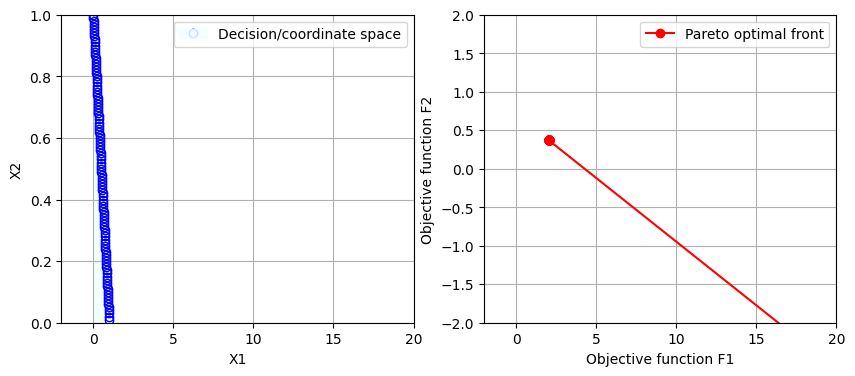

In [65]:
df = pd.read_csv("results.csv", sep=',')

x1_l = np.asarray(df["Beta"])
x2_l = np.asarray(df["1-Beta"])
f1_l = np.asarray(df["Obj1"])
f2_l = np.asarray(df["Obj2"])


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10,4))
edge, = ax1.plot(x1_l,x2_l,'o', markersize=6, markerfacecolor='none', c='b')
shaded = ax1.fill_between(x1_l, x2_l, color='azure', alpha=0.85)
ax1.legend([(edge, shaded)], ['Decision/coordinate space'], loc='best')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_xlim((0,1))
ax1.set_ylim((0,1))
ax1.grid(True)


ax2.plot(f1_l, f2_l, 'o-', c='r', label='Pareto optimal front')
ax2.legend(loc='best')
ax2.set_xlabel('Objective function F1')
ax2.set_ylabel('Objective function F2')
ax2.set_xlim((-2,20))
ax2.set_ylim((-2,2))
ax2.grid(True)
#fig.tight_layout()
plt.show()

[19.65606657 19.65701285 19.65646701 19.65635084 19.65706639 19.65700802
 19.65598229 19.65684943 19.65643711 19.65704078 19.65674488 19.65144865
 19.65710082 19.65672896 19.10692397  2.04475288  2.04475288  2.04632982
  2.04475288  2.04475288  2.05276218  2.04475288  2.04475288  2.04475288
  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288
  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288
  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288
  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288
  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288
  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288
  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288
  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288
  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288  2.04475288
  2.04475288  2.04475288  2.04475288  2.04475288  2

Text(0, 0.5, 'Objective 2')

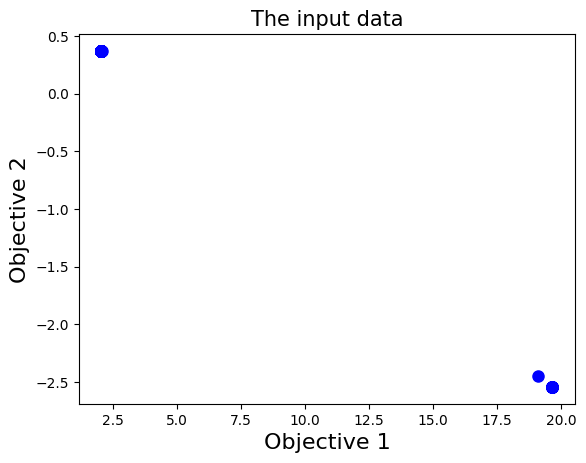

In [69]:
datapoints=np.random.rand(2, 50)

for ii in range(0, datapoints.shape[1]):
  w=datapoints[:,ii]
  fac=.6+.4*np.linalg.norm(w)
  datapoints[:,ii]=(1/fac)*w

obj1 = np.asarray(df["Obj1"])
obj2 = np.asarray(df["Obj2"])
print(obj1)
print(obj2)

h=plt.plot(obj1, obj2, '.b', markersize=16, label='Non Pareto-optimal')
_=plt.title('The input data', fontsize=15)
plt.xlabel('Objective 1', fontsize=16)
plt.ylabel('Objective 2', fontsize=16)

In [75]:
import oapackage

pareto=oapackage.ParetoDoubleLong()

for ii in range(0, datapoints.shape[1]):
  w=oapackage.doubleVector( (datapoints[0,ii], datapoints[1,ii]))
  pareto.addvalue(w, ii)

pareto.show(verbose=1)

Pareto: 6 optimal values, 6 objects


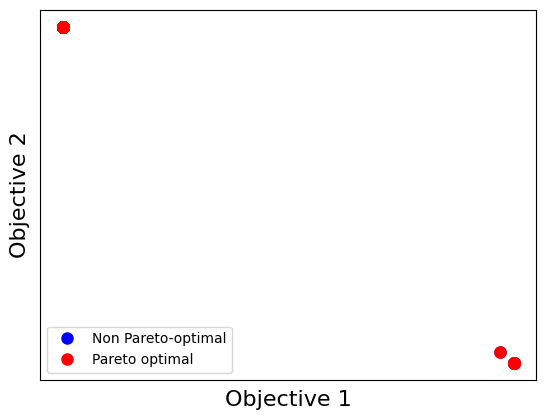

In [78]:
lst=pareto.allindices() # the indices of the Pareto optimal designs

optimal_datapoints=datapoints[:,lst]

h=plt.plot(obj1, obj2, '.b', markersize=16, label='Non Pareto-optimal')
hp=plt.plot(obj1, obj2, '.r', markersize=16, label='Pareto optimal')
plt.xlabel('Objective 1', fontsize=16)
plt.ylabel('Objective 2', fontsize=16)
plt.xticks([])
plt.yticks([])
_=plt.legend(loc=3, numpoints=1)